In [3]:
import multiprocessing
import pickle
import time
time.clock= time.time
import sys

from scipy.special import polygamma as pg
from scipy.special import psi as psi

import numpy as np

SMALL_NUMBER = 1e-100

# This is the LDA implementation to use
# K = number of topics
# eta = hyperparameter for topics (i.e. pseudo word counts)
# alpha = initial Dirichlet hyperparameter
# update_alpha = boolean to determine whether or not alpha is updated at each iteration
# word_index is a dictionary storing the position of each feature in numpy arrays
 # word_index is only used in multi-file as it's important that features are always in the same order.
 # In single file it is created internally
class VariationalLDA(object):
    def __init__(self,corpus=None,K = 20,eta=0.1,
        alpha=1,update_alpha=True,word_index=None,normalise = -1,fixed_topics = None,fixed_topics_metadata = None,
        topic_index = None,top_verbose = True):
        self.corpus = corpus
        self.word_index = word_index
        self.normalise = normalise
        #  If the corpus exists, make the word index and the (unused?) word doc matrix
        if not self.corpus == None:
            self.n_docs = len(self.corpus)
            if self.word_index == None:
                self.word_index = self.find_unique_words()
            if top_verbose:
                print ("Object created with {} documents".format(self.n_docs))
            self.n_words = len(self.word_index)
            self.make_doc_index()
            if self.normalise > -1:
                if top_verbose:
                    print ("Normalising intensities")
                #self.normalise_intensities()
        
        self.K = K

        if fixed_topics:
            self.n_fixed_topics = len(fixed_topics)
            self.K += self.n_fixed_topics
        else:
            self.n_fixed_topics = 0


        self.alpha = alpha
        #  If alpha is a single value, make it into a vector
        if type(self.alpha) == int or type(self.alpha) == float:
            self.alpha = self.alpha*np.ones(self.K)
        self.eta = eta # Smoothing parameter for beta
        self.update_alpha = update_alpha
        self.doc_metadata = None
        

        # self.topic_index = topic_index
        # self.topic_metadata = topic_metadata
        self.topic_index = topic_index
        if not self.topic_index:
            self.topic_index = {}
            self.topic_metadata = {}
            topic_pos = 0
            if fixed_topics:
                for topic_name in fixed_topics:
                    self.topic_index[topic_name] = topic_pos
                    #self.topic_metadata[topic_name] = fixed_topics_metadata[topic_name]
                    #self.topic_metadata[topic_name]['type'] = 'fixed'
                    topic_pos += 1
        
            for topic_pos in range(self.n_fixed_topics,self.K):
                topic_name = 'motif_{}'.format(topic_pos)
                #self.topic_index[topic_name] = topic_pos
                #self.topic_metadata[topic_name] = {'name':topic_name,'type':'learnt'}

        if fixed_topics:
            self._add_exact_fixed_topics(fixed_topics)
            

    def _add_exact_fixed_topics(self,fixed_topics):
        # first add any missing words
        #word_pos = max(self.word_index.values())+1

        #for topic,spectrum in fixed_topics.items():
         #   for word in spectrum:
          #      if not word in self.word_index:
           #         self.word_index[word] = word_pos
            #        word_pos += 1
        #self.n_words = len(self.word_index)

        # Now make the fixed rows of beta
        self.beta_matrix = np.zeros((self.K,self.n_words),np.float64) + SMALL_NUMBER
        #self.beta_matrix[0:50,:] = fixed_topics
        for topic_pos,spectrum in fixed_topics.items():
                for word_pos,val in spectrum.items():
                    self.beta_matrix[topic_pos,word_pos] = val
                self.beta_matrix[topic_pos,:] /= self.beta_matrix[topic_pos,:].sum()


    def create_word_index (self,df):
        word_index = {}
        pos = 0
        for word in list(df.T.columns):
            word_index[word] = pos
            pos += 1
        return word_index
   
    def create_doc_index (self,df):
        self.doc_index = {}
        doc_pos = 0
        for doc in list(df.T.index):
            self.doc_index[doc] = doc_pos
            doc_pos += 1
                
    def load_data_sc(self,df):
        print ("Edited")
        self.n_docs = df.T.shape[0]
        self.word_index = self.create_word_index(df)
        self.create_doc_index(df)
        self.n_words = df.T.shape[1]
        self.corpus = df.T.to_dict(orient="index")
        for doc in self.corpus.keys(): 
            self.corpus[doc] = {key:val for key, val in self.corpus[doc].items() if val != 0}
        
 
        
        
   
    # Run the VB inference. Verbose = True means it gives output each iteration
    # initialise = True initialises (i.e. restarts the algorithm)
    # This means we can run the algorithm from where it got to.
    # First time its run, initialise has to be True
    def run_vb(self,n_its = 1,verbose=True,initialise=True):
        if initialise:
            if verbose:
                print ("Initialising")
            self.init_vb()
        if verbose:
            print ("Starting iterations")
        for it in range(n_its):
            start_time = time.clock()
            diff = self.vb_step()
            end_time = time.clock()
            self.its_performed += 1
            estimated_finish = ((end_time - start_time)*(n_its - it)/60.0)
            if verbose:
                print ("Iteration {} (change = {}) ({} seconds, I think I'll finish in {} minutes). Alpha: ({},{})".format(it,diff,end_time - start_time,estimated_finish,self.alpha.min(),self.alpha.max()))

    # D a VB step
    def vb_step(self):
        # Run an e-step
        temp_beta = self.e_step()
        temp_beta += self.eta
        # Do the normalisation in the m step
        if self.n_fixed_topics > 0:
            temp_beta[:self.n_fixed_topics,:] = self.beta_matrix[:self.n_fixed_topics,:]
        temp_beta /= temp_beta.sum(axis=1)[:,None]
        # Compute how much the word probabilities have changed
        total_difference = (np.abs(temp_beta - self.beta_matrix)).sum()
        self.beta_matrix = temp_beta
        # If we're updating alpha, run the alpha update
        if self.update_alpha:
            self.alpha = self.alpha_nr(init_alpha = self.alpha.copy())
        return total_difference
        # self.m_step()

    # Newton-Raphson procedure for updating alpha
    def alpha_nr(self,maxit=20,init_alpha=[]):
        old_alpha = self.alpha.copy()
        try:
            M,K = self.gamma_matrix.shape
            if not len(init_alpha) > 0:
                init_alpha = self.gamma_matrix.mean(axis=0)/K
            alpha = init_alpha.copy()
            alphap = init_alpha.copy()
            g_term = (psi(self.gamma_matrix) - psi(self.gamma_matrix.sum(axis=1))[:,None]).sum(axis=0)
            for it in range(maxit):
                grad = M *(psi(alpha.sum()) - psi(alpha)) + g_term
                H = -M*np.diag(pg(1,alpha)) + M*pg(1,alpha.sum())


                # playing here....
                z = M*pg(1,alpha.sum())
                h = -M*pg(1,alpha)
                c = ((grad/h).sum())/((1.0/z) + (1.0/h).sum())
                alpha_change = (grad - c)/h

                n_bad = (alpha_change > alpha).sum()
                while n_bad > 0:
                    alpha_change/=2.0
                    n_bad = (alpha_change > alpha).sum()

                
                alpha_new = alpha - alpha_change

                pos = np.where(alpha_new <= SMALL_NUMBER)[0]
                alpha_new[pos] = SMALL_NUMBER

                # if (alpha_new < 0).sum() > 0:
                #   init_alpha /= 10.0
                #   return self.alpha_nr(maxit=maxit,init_alpha = init_alpha)

                diff = np.sum(np.abs(alpha-alpha_new))
                alpha = alpha_new
                if diff < 1e-6 and it > 1:
                    return alpha
        except:
            alpha = old_alpha
        return alpha

    # TODO: tidy up and comment this function
    def e_step(self):
        temp_beta = np.zeros((self.K,self.n_words))
        for doc in self.corpus:
            d = self.doc_index[doc]
            temp_gamma = np.zeros(self.K) + self.alpha
            for word in self.corpus[doc]:
                w = self.word_index[word]
                log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T
                # self.phi_matrix[doc][word] = self.beta_matrix[:,w]*np.exp(psi(self.gamma_matrix[d,:])).T
                # for k in range(self.K):
                #   self.phi_matrix[doc][word][k] = self.beta_matrix[k,w]*np.exp(scipy.special.psi(self.gamma_matrix[d,k]))
                log_phi_matrix = np.exp(log_phi_matrix - log_phi_matrix.max())
                self.phi_matrix[doc][word] = log_phi_matrix/log_phi_matrix.sum()
                # self.phi_matrix[doc][word] /= self.phi_matrix[doc][word].sum()
                temp_gamma += self.phi_matrix[doc][word]*self.corpus[doc][word]
                temp_beta[:,w] += self.phi_matrix[doc][word] * self.corpus[doc][word]
            # self.phi_matrix[d,:,:] = (self.beta_matrix * self.word_matrix[d,:][None,:] * (np.exp(scipy.special.psi(self.gamma_matrix[d,:]))[:,None])).T
            # self.phi_matrix[d,:,:] /= self.phi_matrix[d,:,:].sum(axis=1)[:,None]
            # self.gamma_matrix[d,:] = self.alpha + self.phi_matrix[d,:,:].sum(axis=0)
            self.gamma_matrix[d,:] = temp_gamma
            pos = np.where(self.gamma_matrix[d,:]<SMALL_NUMBER)[0]
            self.gamma_matrix[d,pos] = SMALL_NUMBER
        return temp_beta

    # Function to find the unique words in the corpus and assign them to indices
    def find_unique_words(self):
        word_index = {}
        pos = 0
        for doc in self.corpus:
            for word in self.corpus[doc]:
                if not word in word_index:
                    word_index[word] = pos
                    pos += 1
        print ("Found {} unique words".format(len(word_index)))
        return word_index

    # Pretty sure this matrix is never used
    def make_doc_index(self):
        self.doc_index = {}
        doc_pos = 0
        for doc in self.corpus:
            self.doc_index[doc] = doc_pos
            doc_pos += 1

    # Initialise the VB algorithm
    # TODO: tidy this up
    def init_vb(self):
        # self.gamma_matrix = np.zeros((self.n_docs,self.K),np.float) + 1.0
        # self.phi_matrix = np.zeros((self.n_docs,self.n_words,self.K))
        self.its_performed = 0
        self.phi_matrix = {}
        self.gamma_matrix = np.zeros((self.n_docs,self.K))
        for doc in self.corpus:
            self.phi_matrix[doc] = {}
            for word in self.corpus[doc]:
                self.phi_matrix[doc][word] = np.zeros(self.K)
            d = self.doc_index[doc]
            doc_total = 0.0
            for word in self.corpus[doc]:
                doc_total += self.corpus[doc][word]
            self.gamma_matrix[d,:] = self.alpha + 1.0*doc_total/self.K
        # # Normalise this to sum to 1
        # self.phi_matrix /= self.phi_matrix.sum(axis=2)[:,:,None]

        # Initialise the betas
        if self.n_fixed_topics == 0:
            # self.beta_matrix = np.random.rand(self.K,self.n_words)
            self.beta_matrix = np.zeros((self.K,self.n_words),np.double)
            for k in range(self.K):
                self.beta_matrix[k,:] = np.random.dirichlet(self.eta*np.ones(self.n_words)) 
        else:
            print ("Here")
            for k in range(self.n_fixed_topics,self.K):
                self.beta_matrix[k,:] = np.random.dirichlet(self.eta*np.ones(self.n_words))
        self.beta_matrix /= self.beta_matrix.sum(axis=1)[:,None]

    # Function to return a dictionary with keys equal to documents and values equal to the probability
    # of the requested document (used for visusaling in DESI imaging)
    def get_topic_as_doc_dict(self,topic_id,thresh = 0.001,normalise=False):
        top = {}
        mat = self.gamma_matrix
        if normalise:
            mat = self.get_expect_theta()

        for doc in self.doc_index:
            pos = self.doc_index[doc]
            if mat[pos,topic_id] >= thresh:
                top[doc] = mat[pos,topic_id]
        return top

    # Return a topic as a dictionary over words
    def get_topic_as_dict(self,topic_id):
        top = {}
        for word in self.word_index:
            top[word] = self.beta_matrix[topic_id,self.word_index[word]]
        return top

    # Return the topic probabilities for all documents 
    # Note that self.doc_index maps the document names to their
    # position in this matrix
    def get_expect_theta(self):
        e_theta = self.gamma_matrix.copy()
        e_theta /= e_theta.sum(axis=1)[:,None]
        return e_theta

    def get_beta(self):
        return self.beta_matrix.copy()

    def make_dictionary(self,metadata=None,min_prob_to_keep_beta = 1e-3,
        min_prob_to_keep_phi = 1e-2,min_prob_to_keep_theta = 1e-2,
        filename = None,features = None,compute_overlaps = True):

        if metadata == None:
            if self.doc_metadata == None:
                metadata = {}
                for doc in self.corpus:
                    metadata[doc] = {'name': doc,'parentmass': float(doc.split('_')[0])}
            else:
                metadata = self.doc_metadata

        lda_dict = {}
        lda_dict['corpus'] = self.corpus
        lda_dict['word_index'] = self.word_index
        lda_dict['doc_index'] = self.doc_index
        lda_dict['K'] = self.K
        lda_dict['alpha'] = list(self.alpha)
        lda_dict['beta'] = {}
        lda_dict['doc_metadata'] = metadata
        lda_dict['topic_index'] = self.topic_index
        lda_dict['topic_metadata'] = self.topic_metadata
        
        pure_gamma = []
        for gamma in self.gamma_matrix:
            pure_gamma.append(list(gamma))

        lda_dict['gamma'] = gamma

        if features:
            lda_dict['features'] = features

        # Create the inverse indexes
        wi = []
        for i in self.word_index:
            wi.append((i,self.word_index[i]))
        wi = sorted(wi,key = lambda x: x[1])

        di = []
        for i in self.doc_index:
            di.append((i,self.doc_index[i]))
        di = sorted(di,key=lambda x: x[1])

        ri,i = zip(*wi)
        ri = list(ri)
        di,i = zip(*di)
        di = list(di)

        # make a reverse index for topics
        tp = [(topic,self.topic_index[topic]) for topic in self.topic_index]
        tp = sorted(tp,key = lambda x: x[1])
        reverse,_ = zip(*tp)

        for k in range(self.K):
            pos = np.where(self.beta_matrix[k,:]>min_prob_to_keep_beta)[0]
            motif_name = reverse[k]
            # motif_name = 'motif_{}'.format(k)
            lda_dict['beta'][motif_name] = {}
            for p in pos:
                word_name = ri[p]
                lda_dict['beta'][motif_name][word_name] = self.beta_matrix[k,p]

        eth = self.get_expect_theta()
        lda_dict['theta'] = {}
        for i,t in enumerate(eth):
            doc = di[i]
            lda_dict['theta'][doc] = {}
            pos = np.where(t > min_prob_to_keep_theta)[0]
            for p in pos:
                motif_name = reverse[p]
                # motif_name = 'motif_{}'.format(p)
                lda_dict['theta'][doc][motif_name] = t[p]

        lda_dict['phi'] = {}
        ndocs = 0
        for doc in self.corpus:
            ndocs += 1
            lda_dict['phi'][doc] = {}
            for word in self.corpus[doc]:
                lda_dict['phi'][doc][word] = {}
                pos = np.where(self.phi_matrix[doc][word] >= min_prob_to_keep_phi)[0]
                for p in pos:
                    motif_name = reverse[p]
                    lda_dict['phi'][doc][word][motif_name] = self.phi_matrix[doc][word][p]
            if ndocs % 500 == 0:
                print ("Done {}".format(ndocs))

        if compute_overlaps:
            os = compute_overlap_scores(lda_dict)
            lda_dict['overlap_scores'] = os

        if not filename == None:
            with open(filename,'w') as f:
                pickle.dump(lda_dict,f)

        return lda_dict



In [4]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.patches as mpatches

from scipy import spatial
from scipy.stats import binom
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from scipy.spatial.distance import cosine
from itertools import combinations

stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)


#returns a re-normalised delta: all new topics set to 0; old ones normalised
def deltaCell(cellID,documentTopicMatrix,oldTopics,allTopics):
    theta = documentTopicMatrix.loc[cellID]
    delta = np.zeros(allTopics)
    totalSum = sum(theta[0:oldTopics])
    delta[0:oldTopics] = theta[0:oldTopics]/totalSum
    return delta 


def calculateProbs(cellID, geneName,totalTopics,oldTopics,doubletsMatrix,topicWordsMatrix,documentTopicMatrix):
    total = 0
    total2 = 0
    n = doubletsMatrix.T[cellID].sum()
    x = doubletsMatrix.T[cellID][geneName]
    delta = deltaCell(cellID,documentTopicMatrix,oldTopics, totalTopics)
    p = topicWordsMatrix[geneName][0:totalTopics].values
    prob = (1-binom.cdf(x, n, p))+binom.pmf(x, n, p)
    total = sum(documentTopicMatrix.T[cellID].values*prob)
    total2 = sum(delta*prob)
    return (total, total2)


def expectedActualPlot(geneName,totalTopics,oldTopics,cellMatrix,topicWordsMatrix,documentTopicMatrix,dpi=120):
    x = []
    y = []
    for i in cellMatrix.index:
        t,t1= calculateProbs(i,geneName,totalTopics,oldTopics,cellMatrix,topicWordsMatrix,documentTopicMatrix)
        x.append(t)
        y.append(t1)
    plt.scatter(x,y)
    plt.title(geneName,fontsize=20)
    plt.xlabel("Probability given all topics",fontsize=15)
    plt.ylabel("Probability given initial topics",fontsize=15)
    plt.tight_layout()
    plt.savefig(geneName+"_prob_plot.png",dpi=dpi)
    
    

def lrtest(llmin, llmax):
    lr = -2 * (np.log(llmin)-np.log(llmax))
    p = stats.chisqprob(lr,30)
    return lr, p


#gene ranking per topic
def ranking_genes (oldTopicNum, newTopicsNum,scLDAObject,geneNames):
    interesting_genes = pd.DataFrame()
    for k in range(oldTopicNum,newTopicsNum):
        genesNeed = []
        in_newT = []
        percentages = []
        for geneName in geneNames:
            in_new = 0
            in_old = 0
            for key in scLDAObject.phi_matrix.keys():
                if geneName in scLDAObject.phi_matrix[key].keys():
                    if scLDAObject.phi_matrix[key][geneName].argmax()==k:
                        in_new+=1
                    else:
                        in_old+=1
            if in_new>0:
                genesNeed.append(geneName)
                in_newT.append(in_new)
                percentages.append(in_new/(in_new+in_old))
        ranked_genes = pd.DataFrame([genesNeed,in_newT,percentages,np.full((len(genesNeed),1),k)])
        ranked_genes = ranked_genes.T
        ranked_genes = ranked_genes.sort_values([2,1],ascending=False)
        interesting_genes = pd.concat([interesting_genes,ranked_genes])
    
    return interesting_genes


def ranking_genes_realData (oldTopicNum, newTopicsNum,scLDAObject,geneNames):
    interesting_genes = pd.DataFrame()
    for k in range(oldTopicNum,newTopicsNum):
        genesNeed = []
        in_newT = []
        percentages = []
        for geneName in geneNames:
            in_new = 0
            in_old = 0
            for key in scLDAObject.phi_matrix.keys():
                if geneName in scLDAObject.phi_matrix[key].keys():
                    if scLDAObject.phi_matrix[key][geneName].argmax()==k:
                        in_new+=1
                    else:
                        in_old+=1
            if in_new>0:
                genesNeed.append(geneName)
                in_newT.append(in_new)
                percentages.append(in_new/(in_new+in_old))
        ranked_genes = pd.DataFrame([genesNeed,in_newT,percentages,np.full((len(genesNeed),1),k)])
        ranked_genes = ranked_genes.T
        ranked_genes = ranked_genes.sort_values([2,1],ascending=False)
        interesting_genes = interesting_genes.append(ranked_genes[ranked_genes[1]>10])
        
    return interesting_genes



def getROCarrays(oldT,newT,interesting_genes,ground_truth,cutOffList):
    p = []
    n = []
    for i in cutOffList:
        pos,neg = rocCurveValues(oldT,newT,interesting_genes, ground_truth,i)
        p.append(len(pos))
        n.append(len(list(set(neg))))
    return p,n
    
    
def rocCurveValues(oldT, newT,interesting_genes,ground_truth,topGenesCutOff):
    positive = []
    negative = []
    for i in range(oldT,newT):
        for k in interesting_genes[interesting_genes[3]==i].sort_values([1],ascending=False)[0:topGenesCutOff][0].values:
            if k in ground_truth and k not in positive: 
                positive.append(k)
            if k not in ground_truth:
                negative.append(k)
    return positive, negative



def computeCosine (LDAModel,topic1, topic2):
    t1 = LDAModel.beta_matrix[topic1]
    t2 = LDAModel.beta_matrix[topic2]
    return 1-cosine(t1,t2)


def averageDistance(LDAModel):
    totalDistance = 0
    nT = LDAModel.beta_matrix.shape[0]
    numTopics = [i for i in range(0,nT)]
    combs = combinations(numTopics,2)
    for i in list(combs):
        totalDistance+=computeCosine(LDAModel,i[0],i[1])
    
    totalDistance = totalDistance/(nT*(nT-1)/2)
    return totalDistance

    
    


    

In [5]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sb
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib.transforms import Bbox
#sys.path.append('../code/')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
#from ldaSingleCell import VariationalLDA
#from utilsFuncs import *
import re



In [6]:
my_obj = pd.read_csv('CR.csv', header=0, index_col=0)
my_obj.shape

(23153, 3647)

In [7]:
my_obj.isna().any(axis=1).sum()


0

In [8]:
my_obj = my_obj.dropna()
my_obj.isna().any().sum()


0

In [9]:
my_obj.shape

(23153, 3647)

In [11]:
##Perplexity test for choosing the number of k #######################################
import pandas as pd
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation

dataset = my_obj
print("Done reading file")

numTopics = np.arange(2,20)
valsPerplexity = []

for k in numTopics:
   lda = LatentDirichletAllocation(n_components=k, doc_topic_prior=1, topic_word_prior=0.005)
   output = lda.fit_transform(dataset.T)
    perp = lda.perplexity(dataset.T)
    valsPerplexity.append(int(perp))

print("Writing results")
result = pd.DataFrame({'topics': numTopics, 'perplexity': valsPerplexity})



Done reading file
Writing results


In [15]:
result.to_csv('CR_perplexities.csv', index=False)

<Figure size 800x600 with 0 Axes>

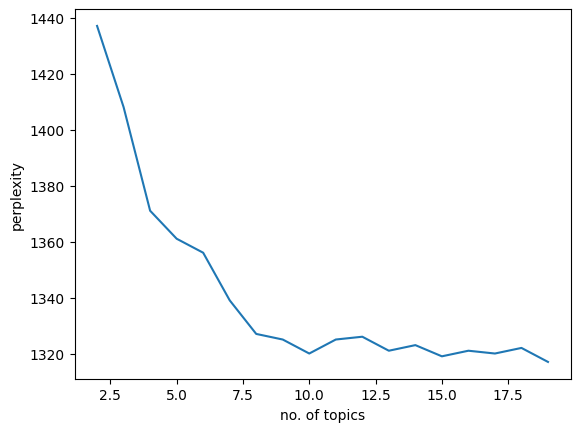

<Figure size 800x600 with 0 Axes>

In [13]:
######plotting the perplexity
import matplotlib.pyplot as plt
perplex= pd.read_csv('CR_perplexities.csv', header=0)
y= perplex['perplexity']
x=perplex['topics']
plt.plot(x, y)
plt.xlabel('no. of topics',fontsize=10)
plt.ylabel('perplexity', fontsize=10)
plt.figure(figsize=(8, 6)) 

In [14]:
Meta= pd.read_csv('CR_meta.csv', header=0, index_col=0)

In [16]:
my_obj.shape

(23153, 3647)

In [17]:
Meta.shape

(3647, 24)

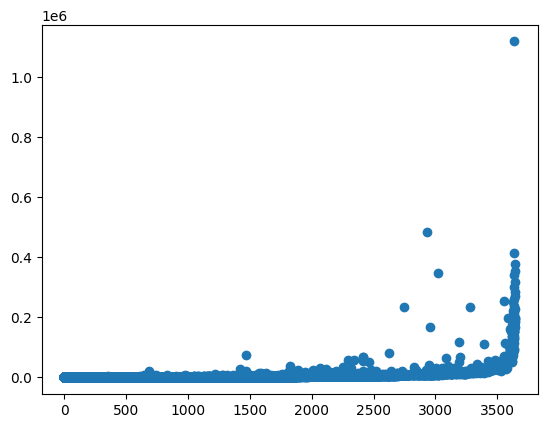

In [19]:
CountsAll= my_obj
plt.plot(CountsAll.astype(bool).sum(axis=1),CountsAll.sum(axis=1),'o')

In [20]:
countsAll= CountsAll
countsAll[(countsAll.astype(bool).sum(axis=1)>100) & (countsAll.astype(bool).sum(axis=1)<10000)]

,AAACGGGGTATAAACG_SOL1303,AAAGTAGGTACCAGTT_SOL1303,AAAGTAGGTCCGAGTC_SOL1303,AAAGTAGGTTCGTCTC_SOL1303,AAATGCCAGCTAGCCC_SOL1303,AAATGCCCATCACAAC_SOL1303,AACCATGCACAAGCCC_SOL1303,AACCATGCAGTCGATT_SOL1303,AACCATGGTGCTTCTC_SOL1303,AACCATGTCGCGTTTC_SOL1303,...,TTTCCTCCAGCTCGAC_SOL012,TTTCCTCCATCACCCT_SOL012,TTTCCTCGTCACCCAG_SOL012,TTTCCTCGTGCACCAC_SOL012,TTTGCGCCACATGGGA_SOL012,TTTGGTTAGCTGTTCA_SOL012,TTTGTCAAGTGGAGAA_SOL012,TTTGTCACAAAGCAAT_SOL012,TTTGTCACACAGTCGC_SOL012,TTTGTCAGTGTTAAGA_SOL012
FO538757.2,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,0,1,0,1
AP006222.2,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,0
SAMD11,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
NOC2L,0,0,0,0,0,1,1,0,2,1,...,1,0,0,0,1,0,1,2,0,0
HES4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC011043.1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
AL592183.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC007325.4,0,0,0,2,0,0,0,0,1,0,...,0,0,0,0,2,0,0,0,0,0
AC004556.1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [21]:
countsFiltered = countsAll[(countsAll.astype(bool).sum(axis=1)>100) & (countsAll.astype(bool).sum(axis=1)<10000)]


In [22]:
countsFiltered

,AAACGGGGTATAAACG_SOL1303,AAAGTAGGTACCAGTT_SOL1303,AAAGTAGGTCCGAGTC_SOL1303,AAAGTAGGTTCGTCTC_SOL1303,AAATGCCAGCTAGCCC_SOL1303,AAATGCCCATCACAAC_SOL1303,AACCATGCACAAGCCC_SOL1303,AACCATGCAGTCGATT_SOL1303,AACCATGGTGCTTCTC_SOL1303,AACCATGTCGCGTTTC_SOL1303,...,TTTCCTCCAGCTCGAC_SOL012,TTTCCTCCATCACCCT_SOL012,TTTCCTCGTCACCCAG_SOL012,TTTCCTCGTGCACCAC_SOL012,TTTGCGCCACATGGGA_SOL012,TTTGGTTAGCTGTTCA_SOL012,TTTGTCAAGTGGAGAA_SOL012,TTTGTCACAAAGCAAT_SOL012,TTTGTCACACAGTCGC_SOL012,TTTGTCAGTGTTAAGA_SOL012
FO538757.2,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,0,1,0,1
AP006222.2,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,0
SAMD11,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
NOC2L,0,0,0,0,0,1,1,0,2,1,...,1,0,0,0,1,0,1,2,0,0
HES4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC011043.1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
AL592183.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC007325.4,0,0,0,2,0,0,0,0,1,0,...,0,0,0,0,2,0,0,0,0,0
AC004556.1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [23]:
p = re.compile("RPS|RPL|RP")
list(filter(p.match,countsFiltered.index.values))

['RP11-345P4.9',
 'RPL22',
 'RP3-510D11.2',
 'RP11-108M9.4',
 'RP1-43E13.2',
 'RPL11',
 'RP4-594I10.3',
 'RPS6KA1',
 'RPA2',
 'RP11-69E11.4',
 'RP1-39G22.7',
 'RP5-1198O20.4',
 'RPS8',
 'RP11-386I14.4',
 'RP5-836J3.1',
 'RP11-486G15.2',
 'RPF1',
 'RP4-621F18.2',
 'RP4-665J23.1',
 'RPAP2',
 'RPL5',
 'RP4-639F20.1',
 'RP11-421L21.3',
 'RP5-1065J22.8',
 'RP11-14N7.2',
 'RP11-337C18.8',
 'RPRD2',
 'RP11-422P24.12',
 'RPS27',
 'RP11-263K19.4',
 'RP1-79C4.4',
 'RP11-296O14.3',
 'RP11-61J19.5',
 'RPS6KC1',
 'RP11-452F19.3',
 'RP11-285F7.2',
 'RP11-295G20.2',
 'RP5-862P8.2',
 'RP5-827C21.4',
 'RP11-488L18.10',
 'RPS7',
 'RP11-254F7.2',
 'RP11-373D23.3',
 'RP11-490M8.1',
 'RP11-89K21.1',
 'RPS27A',
 'RP11-554J4.1',
 'RP11-355B11.2',
 'RPIA',
 'RPL31',
 'RP11-332H14.2',
 'RP11-803D5.4',
 'RP11-65I12.1',
 'RP11-141B14.1',
 'RP11-395A13.2',
 'RPRM',
 'RP11-347P5.1',
 'RP11-686O6.2',
 'RPE',
 'RPL37A',
 'RP11-97C16.1',
 'RPUSD3',
 'RPL32',
 'RPL15',
 'RPSA',
 'RPL14',
 'RP11-708J19.1',
 'RPL29',
 '

In [24]:
countsFiltered = countsFiltered.drop(list(filter(p.match,countsFiltered.index.values)),axis=0)

In [25]:
countsFiltered

,AAACGGGGTATAAACG_SOL1303,AAAGTAGGTACCAGTT_SOL1303,AAAGTAGGTCCGAGTC_SOL1303,AAAGTAGGTTCGTCTC_SOL1303,AAATGCCAGCTAGCCC_SOL1303,AAATGCCCATCACAAC_SOL1303,AACCATGCACAAGCCC_SOL1303,AACCATGCAGTCGATT_SOL1303,AACCATGGTGCTTCTC_SOL1303,AACCATGTCGCGTTTC_SOL1303,...,TTTCCTCCAGCTCGAC_SOL012,TTTCCTCCATCACCCT_SOL012,TTTCCTCGTCACCCAG_SOL012,TTTCCTCGTGCACCAC_SOL012,TTTGCGCCACATGGGA_SOL012,TTTGGTTAGCTGTTCA_SOL012,TTTGTCAAGTGGAGAA_SOL012,TTTGTCACAAAGCAAT_SOL012,TTTGTCACACAGTCGC_SOL012,TTTGTCAGTGTTAAGA_SOL012
FO538757.2,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,0,1,0,1
AP006222.2,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,0
SAMD11,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
NOC2L,0,0,0,0,0,1,1,0,2,1,...,1,0,0,0,1,0,1,2,0,0
HES4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC011043.1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
AL592183.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC007325.4,0,0,0,2,0,0,0,0,1,0,...,0,0,0,0,2,0,0,0,0,0
AC004556.1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [26]:
referenceCells= Meta[Meta['neigb_class']=='Singlet']

In [27]:
Meta.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_label', 'sample_name',
       'patient_id', 'sample_type', 'sample_site', 'label_short', 'percent.mt',
       'tissue', 'RNA_snn_res.0.35', 'seurat_clusters', 'celltype_hpca',
       'celltype_main', 'celltype_fine', 'ScType_cell', 'refined_celltype',
       'new.clusters', 'final_clusters', 'survival', 'stage', 'neigb_class',
       'neigb_type'],
      dtype='object')

In [28]:
referenceCells.head

<bound method NDFrame.head of                          orig.ident  nCount_RNA  nFeature_RNA  \
AAACGGGGTATAAACG_SOL1303         OV        8970          2726   
AAAGTAGGTACCAGTT_SOL1303         OV       11131          3121   
AAAGTAGGTCCGAGTC_SOL1303         OV        7749          2706   
AAAGTAGGTTCGTCTC_SOL1303         OV       18371          4240   
AAATGCCAGCTAGCCC_SOL1303         OV        8316          2261   
...                             ...         ...           ...   
TTTGGTTAGCTGTTCA_SOL012          OV       13849          3321   
TTTGTCAAGTGGAGAA_SOL012          OV       17222          3399   
TTTGTCACAAAGCAAT_SOL012          OV       22800          4338   
TTTGTCACACAGTCGC_SOL012          OV       14027          3405   
TTTGTCAGTGTTAAGA_SOL012          OV       14002          3216   

                                        cell_label sample_name patient_id  \
AAACGGGGTATAAACG_SOL1303  AAACGGGGTATAAACG_SOL1303     SOL1303         P1   
AAAGTAGGTACCAGTT_SOL1303  AAAGTAGGT

In [29]:
referenceCells.index = [i.replace("-",".") for i in referenceCells.index]
referenceCells.index

Index(['AAACGGGGTATAAACG_SOL1303', 'AAAGTAGGTACCAGTT_SOL1303',
       'AAAGTAGGTCCGAGTC_SOL1303', 'AAAGTAGGTTCGTCTC_SOL1303',
       'AAATGCCAGCTAGCCC_SOL1303', 'AAATGCCCATCACAAC_SOL1303',
       'AACCATGCACAAGCCC_SOL1303', 'AACCATGCAGTCGATT_SOL1303',
       'AACCATGGTGCTTCTC_SOL1303', 'AACCATGTCGCGTTTC_SOL1303',
       ...
       'TTTATGCCATCCTAGA_SOL012', 'TTTCCTCCAGCTCGAC_SOL012',
       'TTTCCTCCATCACCCT_SOL012', 'TTTCCTCGTCACCCAG_SOL012',
       'TTTCCTCGTGCACCAC_SOL012', 'TTTGGTTAGCTGTTCA_SOL012',
       'TTTGTCAAGTGGAGAA_SOL012', 'TTTGTCACAAAGCAAT_SOL012',
       'TTTGTCACACAGTCGC_SOL012', 'TTTGTCAGTGTTAAGA_SOL012'],
      dtype='object', length=3401)

In [30]:
countsFiltered.T

,FO538757.2,AP006222.2,SAMD11,NOC2L,HES4,ISG15,AGRN,C1orf159,SDF4,B3GALT6,...,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AC011043.1,AL592183.1,AC007325.4,AC004556.1,AC240274.1
AAACGGGGTATAAACG_SOL1303,0,0,0,0,0,3,0,0,0,0,...,2,59,8,0,67,0,0,0,0,0
AAAGTAGGTACCAGTT_SOL1303,0,0,0,0,0,1,1,0,1,0,...,1,89,12,0,67,0,0,0,1,0
AAAGTAGGTCCGAGTC_SOL1303,0,0,0,0,0,0,0,0,1,0,...,3,48,8,0,55,0,0,0,0,0
AAAGTAGGTTCGTCTC_SOL1303,0,0,1,0,0,0,1,0,3,0,...,0,126,22,0,156,0,0,2,0,0
AAATGCCAGCTAGCCC_SOL1303,0,0,0,0,0,1,0,0,1,0,...,2,118,8,1,84,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTAGCTGTTCA_SOL012,0,0,0,0,0,0,1,0,6,0,...,1,38,8,0,31,0,0,0,0,0
TTTGTCAAGTGGAGAA_SOL012,0,0,0,1,0,0,1,0,4,0,...,2,84,11,0,60,0,0,0,0,0
TTTGTCACAAAGCAAT_SOL012,1,0,0,2,1,1,1,0,1,0,...,1,62,8,0,72,0,0,0,0,0
TTTGTCACACAGTCGC_SOL012,0,1,0,0,0,3,0,0,3,0,...,1,26,5,0,23,0,0,0,0,0


In [31]:
referenceCounts= countsFiltered[referenceCells.index]

In [26]:
referenceCounts

,Olb_Olb_AAGGTTCGTCCAGTTA_SOL006,Olb_Olb_AAGTCTGCATGCATGT_SOL006,Olb_Olb_ACAGCTAAGAGGTTGC_SOL006,Olb_Olb_AGTCTTTAGAGTACCG_SOL006,Olb_Olb_ATAACGCGTAGGAGTC_SOL006,Olb_Olb_CAGCTGGGTCTTTCAT_SOL006,Olb_Olb_CATGGCGCATGGTTGT_SOL006,Olb_Olb_CCAGCGAAGGGTTCCC_SOL006,Olb_Olb_CCAGCGATCGGTTAAC_SOL006,Olb_Olb_CCATTCGAGCTAAGAT_SOL006,...,Qian_scrSOL006_TTGCGTCAGTTGTAGA,Qian_scrSOL006_TTGCGTCCACCTTGTC,Qian_scrSOL006_TTGCGTCTCGAACTGT,Qian_scrSOL006_TTGGCAAGTGACGGTA,Qian_scrSOL006_TTTACTGAGTTACCCA,Qian_scrSOL006_TTTACTGTCACTTCAT,Qian_scrSOL006_TTTGCGCAGGAGTAGA,Qian_scrSOL006_TTTGGTTAGGCATTGG,Qian_scrSOL006_TTTGTCAAGCGGATCA,Qian_scrSOL006_TTTGTCAGTAATTGGA
LINC00115,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM41C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SAMD11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NOC2L,0,0,0,0,1,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
KLHL17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FP565260.7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CU639417.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AP001505.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC099509.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
doubletCells= Meta[Meta['neigb_class']=='Doublet']

In [33]:
doubletCells.head

<bound method NDFrame.head of                          orig.ident  nCount_RNA  nFeature_RNA  \
AAGGCAGAGGCTATCT_SOL1303         OV       20684          3582   
ATCTGCCCAAACAACA_SOL1303         OV       21493          4678   
CATCAGATCGAATGGG_SOL1303         OV       17296          4376   
CCACTACAGTCATCCA_SOL1303         OV       20542          4653   
CGAGCCATCTGGTATG_SOL1303         OV       18289          4485   
...                             ...         ...           ...   
TTGAACGAGTGTCCAT_SOL012          OV       23128          4429   
TTGCCGTTCAAACCGT_SOL012          OV       22199          4060   
TTGGAACGTTAGTGGG_SOL012          OV       27948          4760   
TTTACTGGTCTTCTCG_SOL012          OV       25557          4287   
TTTGCGCCACATGGGA_SOL012          OV       26589          4641   

                                        cell_label sample_name patient_id  \
AAGGCAGAGGCTATCT_SOL1303  AAGGCAGAGGCTATCT_SOL1303     SOL1303         P1   
ATCTGCCCAAACAACA_SOL1303  ATCTGCCCA

In [34]:
doubletCells.index = [i.replace("-",".") for i in doubletCells.index]
doubletCells.index

Index(['AAGGCAGAGGCTATCT_SOL1303', 'ATCTGCCCAAACAACA_SOL1303',
       'CATCAGATCGAATGGG_SOL1303', 'CCACTACAGTCATCCA_SOL1303',
       'CGAGCCATCTGGTATG_SOL1303', 'CGTCACTTCTCGGACG_SOL1303',
       'CGTCCATAGGCAATTA_SOL1303', 'CGTGTAAAGCACCGCT_SOL1303',
       'CGTTCTGGTATAAACG_SOL1303', 'CTGAAGTTCAACCATG_SOL1303',
       ...
       'TGTATTCCAGAAGCAC_SOL012', 'TTCCCAGCAAATACAG_SOL012',
       'TTCTCAACACACGCTG_SOL012', 'TTCTTAGCATGGTAGG_SOL012',
       'TTCTTAGGTTACCAGT_SOL012', 'TTGAACGAGTGTCCAT_SOL012',
       'TTGCCGTTCAAACCGT_SOL012', 'TTGGAACGTTAGTGGG_SOL012',
       'TTTACTGGTCTTCTCG_SOL012', 'TTTGCGCCACATGGGA_SOL012'],
      dtype='object', length=246)

In [35]:
doubletsCounts = countsFiltered[doubletCells.index]
doubletsCounts.shape

(11993, 246)

In [60]:
#setting up LDA
singleCellLDA = VariationalLDA(K = 10,alpha = 1,eta=0.005,update_alpha=True)
singleCellLDA.load_data_sc(referenceCounts)
singleCellLDA.run_vb(n_its = 50,initialise=True)

Edited
Initialising
Starting iterations


/tmp/ipykernel_113568/1579991102.py:223: RuntimeWarning: divide by zero encountered in log
  log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T


Iteration 0 (change = 17.96596251763236) (58.26078414916992 seconds, I think I'll finish in 48.5506534576416 minutes). Alpha: (20.346007577540075,45.90691868311706)
Iteration 1 (change = 0.029167235752382892) (56.954986333847046 seconds, I think I'll finish in 46.51323883930842 minutes). Alpha: (21.2796636307545,48.08748660114491)
Iteration 2 (change = 0.02814234476356404) (56.48869800567627 seconds, I think I'll finish in 45.190958404541014 minutes). Alpha: (21.246987903084726,48.01393871931441)
Iteration 3 (change = 0.02701966780726141) (59.80473804473877 seconds, I think I'll finish in 46.84704480171204 minutes). Alpha: (21.092263722163274,47.64990668985575)
Iteration 4 (change = 0.026011514879910956) (58.88325214385986 seconds, I think I'll finish in 45.14382664362589 minutes). Alpha: (20.92767961738622,47.257549868719835)
Iteration 5 (change = 0.025169535517964865) (61.985931634902954 seconds, I think I'll finish in 46.489448726177216 minutes). Alpha: (20.76892843362854,46.8740472

In [61]:
topic_dict = pd.DataFrame(singleCellLDA.beta_matrix,index=None).to_dict(orient='index')

In [62]:
scLDA = VariationalLDA(corpus=singleCellLDA.corpus,K=20,
                       word_index=singleCellLDA.word_index,
                       alpha=1,eta=0.0005,update_alpha=True, fixed_topics=topic_dict)

Object created with 3401 documents


In [63]:
wordTopic = pd.DataFrame(singleCellLDA.beta_matrix, columns=referenceCounts.index)

In [64]:
scLDA.load_data_sc(doubletsCounts)

Edited


In [65]:
scLDA.run_vb(n_its=100,initialise=True)

Initialising
Here
Starting iterations


/tmp/ipykernel_113568/1579991102.py:223: RuntimeWarning: divide by zero encountered in log
  log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T


Iteration 0 (change = 26.991761543590496) (6.757563829421997 seconds, I think I'll finish in 11.262606382369995 minutes). Alpha: (1.1130571442311903,142.9274232578349)
Iteration 1 (change = 4.935017485857545) (6.149386167526245 seconds, I think I'll finish in 10.146487176418304 minutes). Alpha: (0.8944929484101396,135.69904644658706)
Iteration 2 (change = 3.9053967487189225) (6.17406439781189 seconds, I think I'll finish in 10.084305183092754 minutes). Alpha: (0.7506402460394401,125.84504067904548)
Iteration 3 (change = 3.346586540236515) (6.265520334243774 seconds, I think I'll finish in 10.129257873694103 minutes). Alpha: (0.6368044333916902,117.00999972273593)
Iteration 4 (change = 3.33401836458433) (6.223963737487793 seconds, I think I'll finish in 9.958341979980469 minutes). Alpha: (0.568056940922972,109.00576183882026)
Iteration 5 (change = 4.503132336026516) (6.287805557250977 seconds, I think I'll finish in 9.955692132314047 minutes). Alpha: (0.5209657363352423,100.241770678268

In [66]:
scLDA.beta_matrix.shape

(30, 11993)

In [67]:
scLDA.get_expect_theta().shape

(246, 30)

In [68]:
wordTopicNew = pd.DataFrame(scLDA.beta_matrix, columns=referenceCounts.index)


In [69]:
doubletsCounts.shape

(11993, 246)

In [70]:

interesting_genes = ranking_genes(15,35,scLDA, doubletsCounts.index)

In [71]:
interesting_genes[interesting_genes[3]==18].sort_values(1,ascending=False)[0:20]

,0,1,2,3
2280,PTMS,74,0.334842,[18]
2338,TUBA1B,55,0.234043,[18]
2751,TPM1,54,0.272727,[18]
385,MRPL33,53,0.226496,[18]
2279,MLF2,49,0.219731,[18]
2953,APRT,47,0.20614,[18]
850,NCBP2,47,0.242268,[18]
3148,SNRPD1,46,0.207207,[18]
1067,ATOX1,46,0.212963,[18]
3561,ISOC2,46,0.261364,[18]


In [72]:
#interesting_genes.to_csv('CR_FibCan_genes.csv', index=False)
interesting_genes.to_csv('CR_new_genes.csv', index=False)

In [73]:
interesting_genes= pd.read_csv('CR_new_genes.csv', header=0)


In [56]:
interesting_genes.head

<bound method NDFrame.head of              0  1         2     3
0        F13A1  3  0.600000  [15]
1       ATP10A  3  0.600000  [15]
2        ABCD1  6  0.545455  [15]
3         GIN1  6  0.500000  [15]
4      SLC26A6  3  0.500000  [15]
...        ... ..       ...   ...
83156    EIF3E  1  0.004065  [31]
83157   MALAT1  1  0.004065  [31]
83158      B2M  1  0.004065  [31]
83159      FTL  1  0.004065  [31]
83160   MT-CO2  1  0.004065  [31]

[83161 rows x 4 columns]>

In [58]:
interesting_genes= pd.read_csv('CR_FibCan_genes.csv', header=0)

In [59]:
interesting_genes.head

<bound method NDFrame.head of              0   1         2     3
0        VIPR2   5  1.000000  [10]
1        KCNA1   1  1.000000  [10]
2          CPM  23  0.638889  [10]
3       SLC7A7  12  0.631579  [10]
4        REP15   3  0.600000  [10]
...        ...  ..       ...   ...
105539  EIF4A2   1  0.004065  [29]
105540   EIF3E   1  0.004065  [29]
105541   PFDN5   1  0.004065  [29]
105542   UBA52   1  0.004065  [29]
105543  MT-ND1   1  0.004065  [29]

[105544 rows x 4 columns]>